In [1]:
import numpy as np
import numpy.random as rd
import scipy.stats as st
import copy, time, os
from datetime import datetime as dt

from multiprocessing import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)


## 簡易的な並列処理

In [2]:
def test_calc(num):
    """重い処理"""
    _sum = 0
    for i in xrange(num):
        _sum += i
    return _sum

In [3]:
# シーケンシャルに2回実行した時の時間を計測
start = time.time()
_sum = 0
for _ in xrange(2):
    _sum += test_calc(100000000)
end = time.time()
print _sum
print "time: {}".format(end-start)

9999999900000000
time: 11.6906960011


In [4]:
# 2プロセスで実行した時の時間を計測
n_worker = 2

pool = Pool(processes=n_worker)

# 2つのプロセスが実行する関数に渡す引数リスト
args = [100000000] * n_worker

start = time.time() # 計測
result = pool.map(test_calc, args)
end = time.time()   # 計測

print  np.sum(result)
print "time: {}".format(end-start)
pool.close()

9999999900000000
time: 6.28346395493


## MCMCの並列処理

In [5]:
# 確率関数から正規化定数を除いたもの
def P(x1, x2, b):
    assert np.abs(b) < 1
    return np.exp(-0.5*(x1**2 - 2*b*x1*x2 + x2**2))

In [6]:
# global parameters
b = 0.5
delta = 1

def now():
    return  dt.strftime(dt.now(), '%H:%M:%S')

def exec_sampling(n_samples):
    global b, delta
    rd.seed(int(time.time())+os.getpid())
    pid = os.getpid()
    start = time.time()
    start_time = now()
    
    #initial state
    sampling_result = []
    current = np.array([5, 5])
    sampling_result.append(current)
    cnt = 1
    while cnt < n_samples:
        # rv from proposal distribution(Normal Dist: N(0, delta) )
        next = current + rd.normal(0, delta, size=2)
        r = P(next[0], next[1], b)/P(current[0], current[1], b)

        if r > 1 or r > rd.uniform(0, 1):
            # 0-1の一様乱数がrより大きい時は状態を更新する。 
            current = copy.copy(next)
            sampling_result.append(current)
            cnt += 1
            
    end = time.time()    
    end_time = now()
    print "PID:{}, exec time: {}, {}-{}".format(pid, end-start, start_time, end_time)
    return sampling_result


In [7]:
def draw_scatter(sample, alpha=0.3):
    plt.figure(figsize=(9,9))
    plt.scatter(sample[:,0], sample[:,1], alpha=alpha)
    plt.title("Scatter plot of 2-dim normal random variable with MCMC. sample size:{}".format(len(sample)))
    plt.show()
    
def draw_traceplot(sample):
    assert sample.shape[1] == 2
    
    plt.figure(figsize=(15, 6))
    
    for i in range(2):
        plt.subplot(2, 1, i+1)
        plt.xlim(0, len(sample[:,i]))
        plt.plot(sample[:,i], lw=0.05)
        if i == 0:
            order = "1st"
        else:
            order = "2nd"
        plt.title("Traceplot of {} parameter.".format(order))
    
    plt.show()

def remove_burn_in_samples(total_sampling_result, burn_in_rate=0.2):
    adjust_burn_in_result = []
    for i in xrange(len(total_sampling_result)):
        idx = int(len(total_sampling_result[i])*burn_in_rate)
        adjust_burn_in_result.extend(total_sampling_result[i][idx:])
    return np.array(adjust_burn_in_result)

def parallel_exec(n_samples, n_chain, burn_in_rate=0.2):
    # 並列処理の実行
    n_samples_per_chain = n_samples / float(n_chain)
    print "Making {} samples per {} chain. Burn-in rate:{}".format(n_samples_per_chain, n_chain, burn_in_rate)
    pool = Pool(processes=n_chain)
    n_trials_per_process = [n_samples_per_chain] * n_chain
    start = time.time()
    total_sampling_result = pool.map(exec_sampling, n_trials_per_process)
    end = time.time()
    print "total exec time: {}".format(end-start)

    # Drawing scatter plot
    adjusted_samples = remove_burn_in_samples(total_sampling_result)
    draw_scatter(adjusted_samples, alpha=0.01)
    draw_traceplot(adjusted_samples)
    pool.close()

Making 250000.0 samples per 4 chain. Burn-in rate:0.2
total exec time: 20.6252059937
PID:2380, exec time: 14.8654129505, 20:55:00-20:55:15
PID:2381, exec time: 14.8769938946, 20:55:00-20:55:15
PID:2383, exec time: 14.8749108315, 20:55:00-20:55:15
PID:2382, exec time: 14.8953499794, 20:55:00-20:55:15


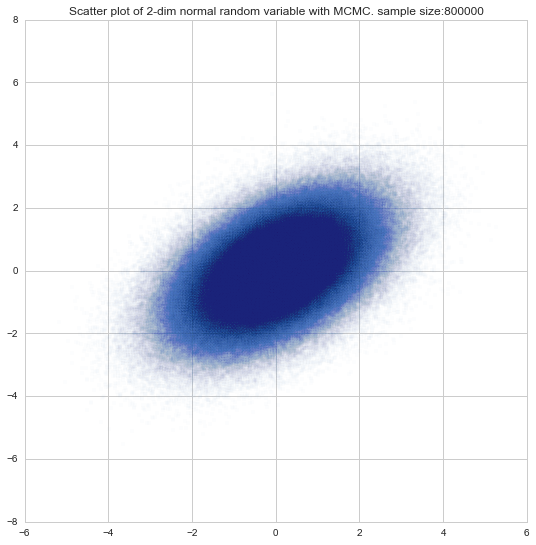

In [ ]:
# パラメーター: n_samples = 1000000, n_chain   = 4
parallel_exec(1000000, 4)

Making 333333.333333 samples per 3 chain. Burn-in rate:0.2
total exec time: 18.2799339294
PID:2369, exec time: 12.3520510197, 20:53:15-20:53:28
PID:2368, exec time: 12.5000309944, 20:53:15-20:53:28
PID:2370, exec time: 12.5926179886, 20:53:15-20:53:28


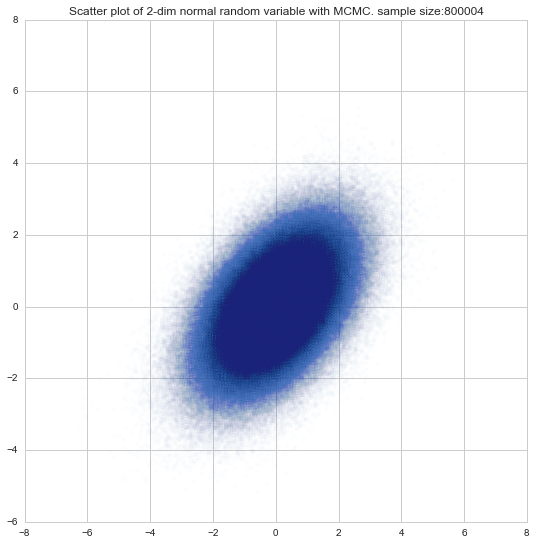

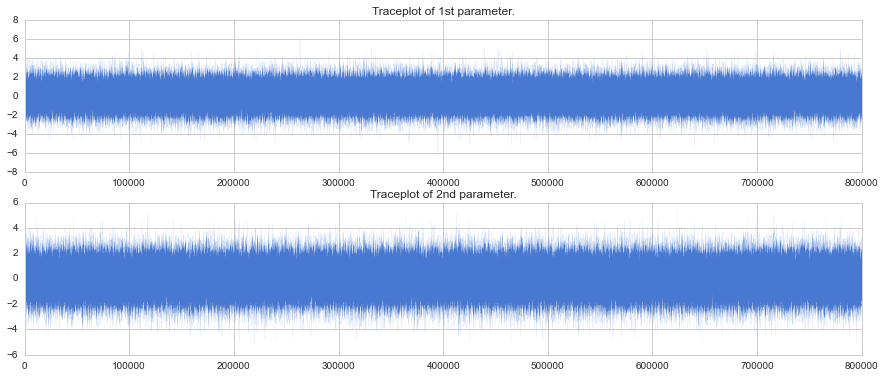

In [9]:
# パラメーター: n_samples = 1000000, n_chain   = 3
parallel_exec(1000000, 3)

Making 500000.0 samples per 2 chain. Burn-in rate:0.2
total exec time: 18.6980280876
PID:2374, exec time: 12.0037689209, 20:53:41-20:53:53
PID:2373, exec time: 11.9927477837, 20:53:41-20:53:53


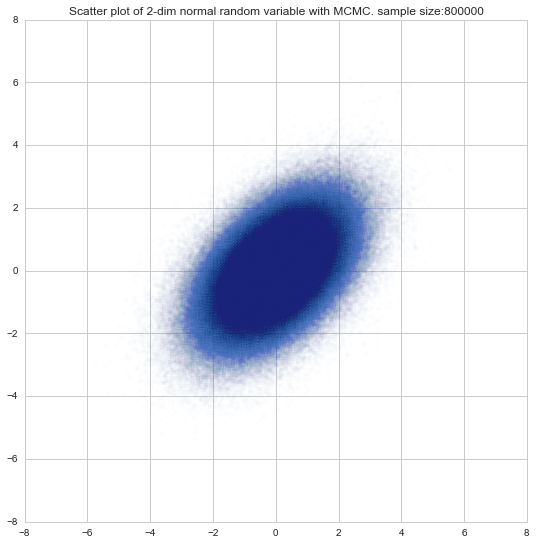

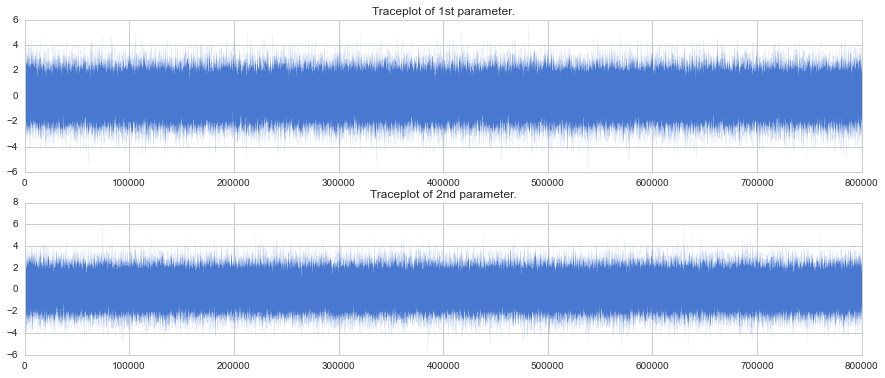

In [10]:
# パラメーター: n_samples = 1000000, n_chain   = 2
parallel_exec(1000000, 2)

Making 1000000.0 samples per 1 chain. Burn-in rate:0.2
total exec time: 32.683218956
PID:2377, exec time: 24.7304420471, 20:54:07-20:54:31


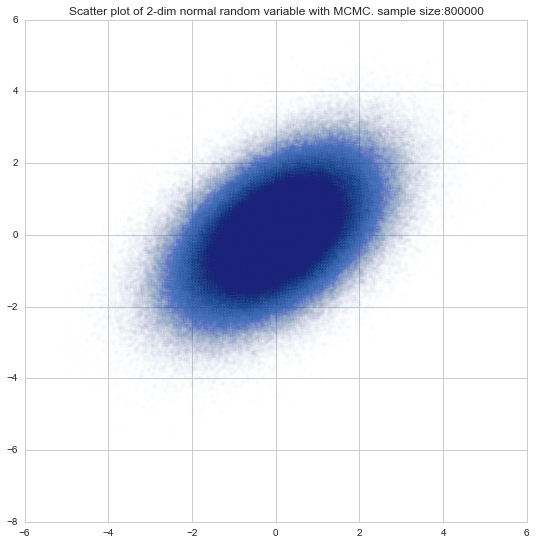

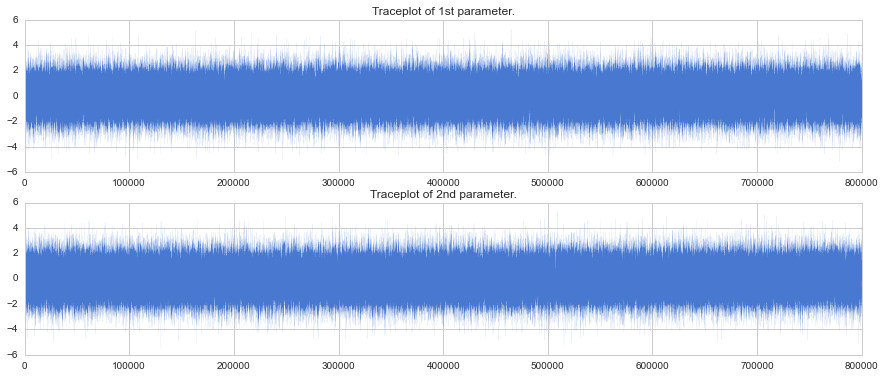

In [11]:
# パラメーター: n_samples = 1000000, n_chain   = 1
parallel_exec(1000000, 1)